- Extract topological barcodes (H0 & H1) from final time-step
- Compute Euler characteristic and Betti curves
- Compute statistics for # neighbors, # intervals and interval lengths
- Plot representatives for individual, branching & clustered phenotypes
- Relationship with percolation theory
    - https://en.wikipedia.org/wiki/Percolation_threshold

In [1]:
using MAT
using NPZ
using PyPlot
using Eirene
using Statistics
using Distributions
using DelimitedFiles
# using StatsBase (for ecdf)

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-5399741466385391486\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-12548552641066570002\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-5399741466385391486\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

### Barcode Statistics

In [2]:
function get_betti_curves(TDA_barcode_dim0, TDA_barcode_dim1)
    
    dim0_bar_lengths = TDA_barcode_dim0[:,2] - TDA_barcode_dim0[:,1]
    dim1_bar_lengths = TDA_barcode_dim1[:,2] - TDA_barcode_dim1[:,1]
    
    N = size(dim0_bar_lengths)[1]
    L = 20
    
    s_idx = sortperm(dim0_bar_lengths, alg=QuickSort)
    TDA_barcode_dim0_sorted = TDA_barcode_dim0[s_idx,:]
    
    s_idx = sortperm(dim1_bar_lengths, alg=QuickSort)
    TDA_barcode_dim1_sorted = TDA_barcode_dim1[s_idx,:]
    
    betti_0 = []
    betti_1 = []
    phi_vals = []
    eta_vals = []
    chi_vals = []
    
    for eps in range(0, stop=10, step=0.01)
        
        η = (N*π*(eps^2))/(L^2)
        ϕ = 1 - exp(-η)
        
        valid_dim0 = TDA_barcode_dim0[:,2][.&(TDA_barcode_dim0[:,1] .<= eps, TDA_barcode_dim0[:,2] .>= eps)]
        valid_dim1 = TDA_barcode_dim1[:,2][.&(TDA_barcode_dim1[:,1] .<= eps, TDA_barcode_dim1[:,2] .>= eps)]
        
        norm_betti_0 = size(valid_dim0)[1] / N
        norm_betti_1 = size(valid_dim1)[1] / N
        
        χ = norm_betti_0 - norm_betti_1
        
        append!(phi_vals, ϕ)
        append!(eta_vals, η)
        append!(betti_0, norm_betti_0)
        append!(betti_1, norm_betti_1)
        append!(chi_vals, χ)
        
    end
    
    return (betti_0, betti_1, phi_vals, eta_vals, chi_vals)
    
end;

#### Without proliferation

In [3]:
parent_folder = "no_prolif_timelapse";
conditions = ["Clustered", "Spanning", "SpanningWClusters", "Individual"];
repetitions = 1:10;

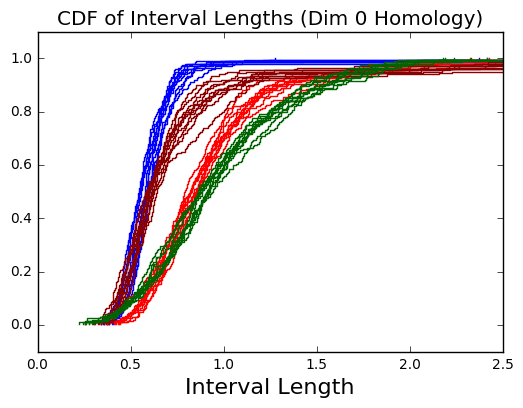

In [4]:
figure(figsize=(6,4), dpi=300)

for cond in conditions
    
    for rep in repetitions
        
        filepath = parent_folder * "/" * cond * "_" * string(rep) * "_rep/Pos_200000.dat"
        
        posarray = readdlm(filepath, ',', '\n');
        posx = [];
        posy = []
        for j in 1:size(posarray)[2]
            complex_num = parse(Complex{Float64}, posarray[j])
            push!(posx, real(complex_num));
            push!(posy, imag(complex_num));
        end
        
        final_positions = transpose(hcat(posx, posy));
        
        pers_diag = eirene(final_positions, model="pc", maxdim=1);
        
        TDA_barcode_dim0 = barcode(pers_diag, dim=0)
        TDA_barcode_dim1 = barcode(pers_diag, dim=1)

        dim0_bar_lengths = TDA_barcode_dim0[:,2] - TDA_barcode_dim0[:,1]
        dim1_bar_lengths = TDA_barcode_dim1[:,2] - TDA_barcode_dim1[:,1]
        
        # hist(dim1_bar_lengths, 200, normed=true, cumulative=true, color="red", histtype="step")
        
        # cdf_eval_fn = ecdf(dim0_bar_lengths)
        # cdf_eval_fn = ecdf(dim1_bar_lengths)
        # x_vals = range(0, stop=3, length=200)
        # y_vals = cdf_eval_fn(x_vals)
        
        n = length(dim0_bar_lengths)
        x_vals = sort(dim0_bar_lengths)
        y_vals = float(1:n)/n
        
        if cond == "Clustered"
            if rep == 1
                step(x_vals, y_vals, color="blue", label="Clustered")
            else
                step(x_vals, y_vals, color="blue")
            end
        elseif cond == "Spanning"
            if rep == 1
                step(x_vals, y_vals, color="red", label="Branching")
            else
                step(x_vals, y_vals, color="red")
            end
        elseif cond == "SpanningWClusters"
            if rep == 1
                step(x_vals, y_vals, color="darkred", label="Branching w/ Clusters")
            else
                step(x_vals, y_vals, color="darkred")
            end
        else
            if rep == 1
                step(x_vals, y_vals, color="darkgreen", label="Individual")
            else
                step(x_vals, y_vals, color="darkgreen")
            end
        end
        
    end
    
end

ylim([-0.1, 1.1]);
xlim([0.0, 2.5]);
yticks(fontsize=10)
xticks(fontsize=10)
#legend(loc=4, fontsize=10);
xlabel("Interval Length", fontsize=16);
title("CDF of Interval Lengths (Dim 0 Homology)");

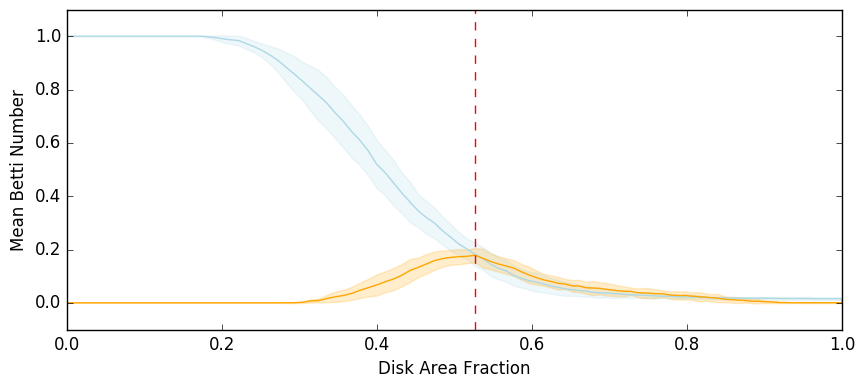

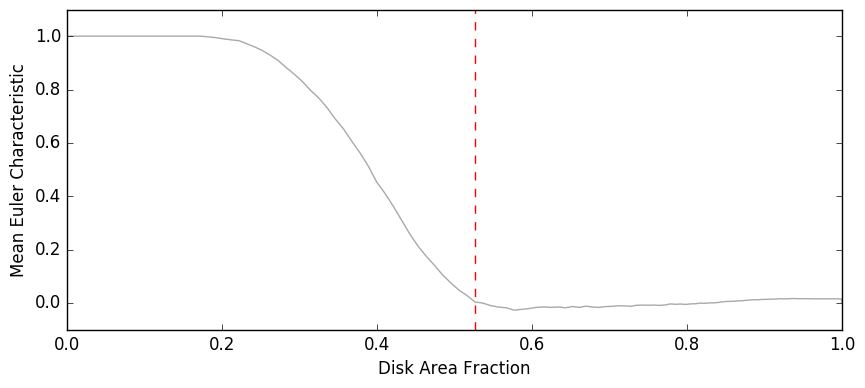

ϕ_c = 0.526619669022803 (est.)

In [5]:
cond = "Clustered" 

betti_0_reps = zeros(size(repetitions)[1], 1001)
betti_1_reps = zeros(size(repetitions)[1], 1001)
euler_characteristics = zeros(size(repetitions)[1], 1001)

phi_vals = nothing
eta_vals = nothing

for rep in repetitions
        
    filepath = parent_folder * "/" * cond * "_" * string(rep) * "_rep/Pos_200000.dat"

    posarray = readdlm(filepath, ',', '\n');
    posx = [];
    posy = []
    for j in 1:size(posarray)[2]
        complex_num = parse(Complex{Float64}, posarray[j])
        push!(posx, real(complex_num));
        push!(posy, imag(complex_num));
    end

    final_positions = transpose(hcat(posx, posy));

    pers_diag = eirene(final_positions, model="pc", maxdim=1);

    TDA_barcode_dim0 = barcode(pers_diag, dim=0)
    TDA_barcode_dim1 = barcode(pers_diag, dim=1)

    (b0, b1, phi, eta, chi) = get_betti_curves(TDA_barcode_dim0, TDA_barcode_dim1);
    
    phi_vals = phi
    eta_vals = eta
    
    betti_0_reps[rep,:] = b0
    betti_1_reps[rep,:] = b1
    euler_characteristics[rep,:] = chi
    
end

mean_betti_0 = mean(betti_0_reps, dims=1)
mean_betti_1 = mean(betti_1_reps, dims=1)
mean_betti_0 = reduce(vcat, mean_betti_0)
mean_betti_1 = reduce(vcat, mean_betti_1)

std_betti_0 = std(betti_0_reps, dims=1)
std_betti_0 = reduce(vcat, std_betti_0)
std_betti_1 = std(betti_1_reps, dims=1)
std_betti_1 = reduce(vcat, std_betti_1)

χ̄ = mean(euler_characteristics, dims=1)
χ̄ = reduce(vcat, χ̄)

cur_diff = 1.0
cur_idx = 0
cnt = 1

for ec_val in χ̄
    
    if abs(ec_val - 0.0) < cur_diff
        cur_diff = ec_val
        cur_idx = cnt
    end
    if ec_val < 0
       break 
    end
    cnt += 1
    
end
ϕ_c = phi_vals[cnt-1]
print("ϕ_c = " * string(ϕ_c) * " (est.)")

figure(figsize=(10,4), dpi=300)
fill_between(phi_vals, mean_betti_0-std_betti_0, mean_betti_0+std_betti_0, color="lightblue", alpha=0.2)
fill_between(phi_vals, mean_betti_1-std_betti_1, mean_betti_1+std_betti_1, color="orange", alpha=0.2)
plot(phi_vals, mean_betti_0, color="lightblue", "-")
plot(phi_vals, mean_betti_1, color="orange", "-")
if ϕ_c < 0.99
    plot([ϕ_c, ϕ_c], [-0.1, 1.1], color="red", "--")
end
xlim([0, 1])
ylim([-0.1, 1.1])
xlabel("Disk Area Fraction")
ylabel("Mean Betti Number")
show()

figure(figsize=(10,4), dpi=300)
plot(phi_vals, χ̄, color="darkgray", "-")
if ϕ_c < 0.99
    plot([ϕ_c, ϕ_c], [-0.1, 1.1], color="red", "--")
end
xlim([0, 1])
ylim([-0.1, 1.1])
xlabel("Disk Area Fraction")
ylabel("Mean Euler Characteristic")
show()

In [6]:
num_loops = Dict()
loop_size = Dict()
num_neighbors = Dict()

for cond in conditions
    
    num_loops[cond] = []
    loop_size[cond] = []
    num_neighbors[cond] = []
    
    for rep in repetitions
        
        filepath = parent_folder * "/" * cond * "_" * string(rep) * "_rep/Pos_200000.dat"
        
        posarray = readdlm(filepath, ',', '\n');
        posx = [];
        posy = []
        for j in 1:size(posarray)[2]
            complex_num = parse(Complex{Float64}, posarray[j])
            push!(posx, real(complex_num));
            push!(posy, imag(complex_num));
        end
        
        final_positions = transpose(hcat(posx, posy));
        
        filepath = parent_folder * "/" * cond * "_" * string(rep) * "_rep/Neighbors_200000.dat"
        neighbors = readdlm(filepath, ',', '\n')
        
        pers_diag = eirene(final_positions, model="pc", maxdim=1);
        
        TDA_barcode_dim1 = barcode(pers_diag, dim=1)
        
        dim1_bar_lengths = TDA_barcode_dim1[:,2] - TDA_barcode_dim1[:,1]
        filtered_dim1_bars = TDA_barcode_dim1[:,2][TDA_barcode_dim1[:,2] .> 1.4269414844344528]
        
        n_loops = size(filtered_dim1_bars)[1]
        
        append!(num_loops[cond], mean(n_loops))
        append!(loop_size[cond], filtered_dim1_bars)
        append!(num_neighbors[cond], mean(neighbors))
    
    end
    
end

In [7]:
npzwrite("no_prolif_num_neighbors.npz", Dict(
    "individual" => convert(Array{Float64,1}, num_neighbors["Individual"]),
    "spanning" => convert(Array{Float64,1}, num_neighbors["Spanning"]), 
    "spanningwclusters" => convert(Array{Float64,1}, num_neighbors["SpanningWClusters"]), 
    "clustered" => convert(Array{Float64,1}, num_neighbors["Clustered"])))

npzwrite("no_prolif_loop_diameters.npz", Dict(
    "individual" => convert(Array{Float64,1}, loop_size["Individual"]),
    "spanning" => convert(Array{Float64,1}, loop_size["Spanning"]),
    "spanningwclusters" => convert(Array{Float64,1}, loop_size["SpanningWClusters"]),
    "clustered" => convert(Array{Float64,1}, loop_size["Clustered"])))

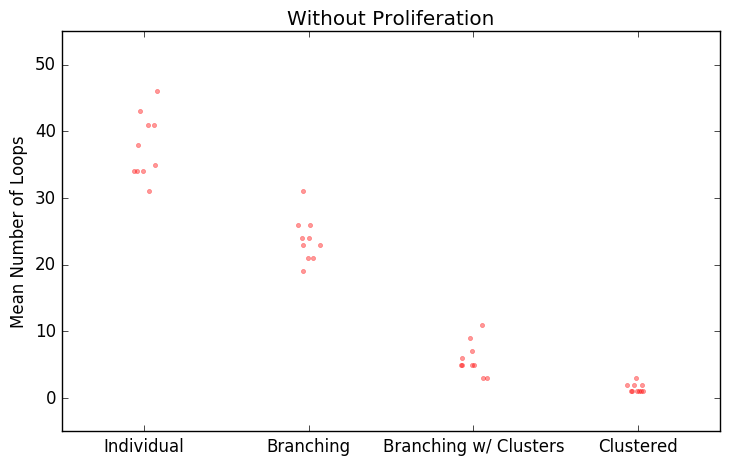

In [8]:
fig = figure(1, figsize=(8.5,5), dpi=300)
ax = fig.add_subplot(111)

median_properties = Dict()
median_properties["color"] = "blue"
median_properties["linewidth"] = 0.0
whisker_properties = Dict()
whisker_properties["linewidth"] = 0.0

bp = ax.boxplot([num_loops["Individual"], num_loops["Spanning"], num_loops["SpanningWClusters"], 
    num_loops["Clustered"]], 
    showbox=false, showcaps=false, showfliers=false, medianprops=median_properties, 
    whiskerprops=whisker_properties)

xticlabels = ["Individual", "Spanning", "SpanningWClusters", "Clustered"]
xticdisp = ["Individual", "Branching", "Branching w/ Clusters",  "Clustered"]
xticks([1, 2, 3, 4], xticdisp);

for i in [1, 2, 3, 4]
    ys = num_loops[xticlabels[i]]
    xs = rand(Normal(i, 0.04), size(ys)[1])
    plot(xs, ys, "r.", alpha=0.4)
end

ylabel("Mean Number of Loops")
title("Without Proliferation")
ylim([-5, 55])
fig.savefig("no_prolif_num_loops.png", bbox_inches="tight")

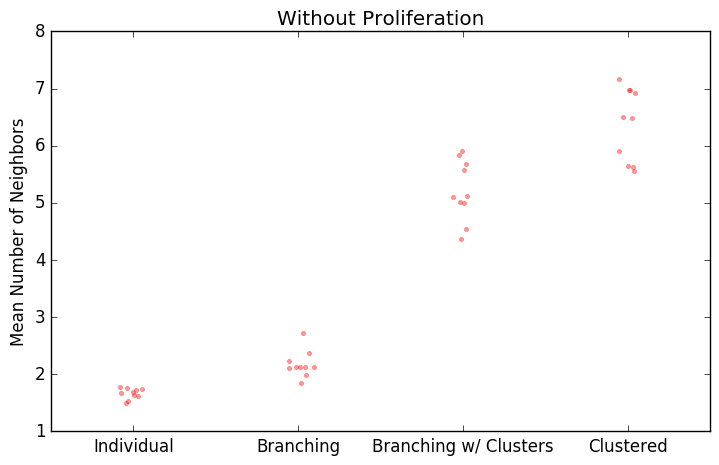

In [9]:
fig = figure(1, figsize=(8.5,5), dpi=300)
ax = fig.add_subplot(111)

median_properties = Dict()
median_properties["color"] = "blue"
median_properties["linewidth"] = 0.0
whisker_properties = Dict()
whisker_properties["linewidth"] = 0.0

bp = ax.boxplot([num_neighbors["Individual"], num_neighbors["Spanning"], num_neighbors["SpanningWClusters"], 
    num_neighbors["Clustered"]], 
    notch=false, showbox=false, showcaps=false, showfliers=false,
    medianprops=median_properties, whiskerprops=whisker_properties)

xticlabels = ["Individual", "Spanning", "SpanningWClusters", "Clustered"]
xticdisp = ["Individual", "Branching", "Branching w/ Clusters", "Clustered"]
xticks([1, 2, 3, 4], xticdisp);

for i in [1, 2, 3, 4]
    ys = num_neighbors[xticlabels[i]]
    xs = rand(Normal(i, 0.04), size(ys)[1])
    plot(xs, ys, "r.", alpha=0.4)
end

ylabel("Mean Number of Neighbors")
title("Without Proliferation")
#ylim([-1, 12])
ylim([1, 8])
fig.savefig("no_prolif_num_neighbors.png", bbox_inches="tight")

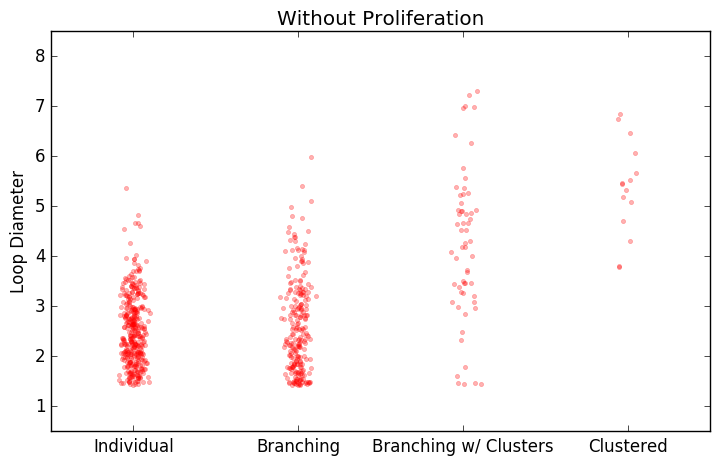

In [10]:
fig = figure(1, figsize=(8.5,5), dpi=300)
ax = fig.add_subplot(111)

median_properties = Dict()
median_properties["color"] = "blue"
median_properties["linewidth"] = 0.0
whisker_properties = Dict()
whisker_properties["linewidth"] = 0.0

bp = ax.boxplot([loop_size["Individual"], loop_size["Spanning"], loop_size["SpanningWClusters"],
    loop_size["Clustered"]], 
    notch=false, showbox=false, showcaps=false, showfliers=false,
    medianprops=median_properties, whiskerprops=whisker_properties)

xticlabels = ["Individual", "Spanning", "SpanningWClusters", "Clustered"]
xticdisp = ["Individual", "Branching", "Branching w/ Clusters", "Clustered"]
xticks([1, 2, 3, 4], xticdisp);

for i in [1, 2, 3, 4]
    ys = loop_size[xticlabels[i]]
    xs = rand(Normal(i, 0.04), size(ys)[1])
    plot(xs, ys, "r.", alpha=0.3)
end

ylabel("Loop Diameter")
title("Without Proliferation")
ylim([0.5, 8.5])
fig.savefig("no_prolif_loop_radii.png", bbox_inches="tight")

In [11]:
# equilibrium distance
r_eq = 1.009

# effective particle size
sigma = r_eq/2 

cond = "Clustered"
num_loops_min = minimum(num_loops[cond])
num_loops_max = maximum(num_loops[cond])
loop_dm = mean(loop_size[cond])/sigma

print(cond * " Condition\n")
print("Number of loops in range: " * repr(num_loops_min) * " - " * repr(num_loops_max) * "\n")
print("Mean Loop Diameter: " * repr(loop_dm) * " sigma\n")
print("Mean Loop Diameter: " * repr(mean(loop_size[cond])) * "\n")

Clustered Condition
Number of loops in range: 1.0 - 3.0
Mean Loop Diameter: 10.631118186512367 sigma
Mean Loop Diameter: 5.363399125095489


#### With proliferation enabled

In [12]:
parent_folder = "prolif_timelapse";
conditions = ["Clustered", "Spanning", "SpanningWClusters"];
repetitions = 1:10;

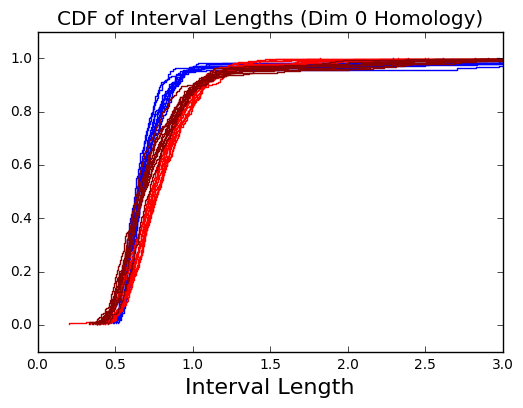

In [13]:
figure(figsize=(6,4), dpi=300)

for cond in conditions
    
    for rep in repetitions
        
        filepath = parent_folder * "/" * cond * "_" * string(rep) * "_rep/Pos_200000.dat"
        
        posarray = readdlm(filepath, ',', '\n');
        posx = [];
        posy = []
        for j in 1:size(posarray)[2]
            complex_num = parse(Complex{Float64}, posarray[j])
            push!(posx, real(complex_num));
            push!(posy, imag(complex_num));
        end
        
        final_positions = transpose(hcat(posx, posy));
        
        pers_diag = eirene(final_positions, model="pc", maxdim=1);
        
        TDA_barcode_dim0 = barcode(pers_diag, dim=0)
        TDA_barcode_dim1 = barcode(pers_diag, dim=1)

        dim0_bar_lengths = TDA_barcode_dim0[:,2] - TDA_barcode_dim0[:,1]
        dim1_bar_lengths = TDA_barcode_dim1[:,2] - TDA_barcode_dim1[:,1]
        
        # hist(dim1_bar_lengths, 200, normed=true, cumulative=true, color="red", histtype="step")
        
        # cdf_eval_fn = ecdf(dim0_bar_lengths)
        # cdf_eval_fn = ecdf(dim1_bar_lengths)
        # x_vals = range(0, stop=3, length=200)
        # y_vals = cdf_eval_fn(x_vals)
        
        n = length(dim0_bar_lengths)
        x_vals = sort(dim0_bar_lengths)
        y_vals = float(1:n)/n
        
        if cond == "Clustered"
            if rep == 1
                step(x_vals, y_vals, color="blue", label="Clustered")
            else
                step(x_vals, y_vals, color="blue")
            end
        elseif cond == "Spanning"
            if rep == 1
                step(x_vals, y_vals, color="red", label="Branching")
            else
                step(x_vals, y_vals, color="red")
            end
        else
            if rep == 1
                step(x_vals, y_vals, color="darkred", label="Branching w/ Clusters")
            else
                step(x_vals, y_vals, color="darkred")
            end
        end
        
    end
    
end

ylim([-0.1, 1.1]);
xlim([0.0, 3.0]);
yticks(fontsize=10)
xticks(fontsize=10)
#legend(loc=4, fontsize=10);
xlabel("Interval Length", fontsize=16);
title("CDF of Interval Lengths (Dim 0 Homology)");

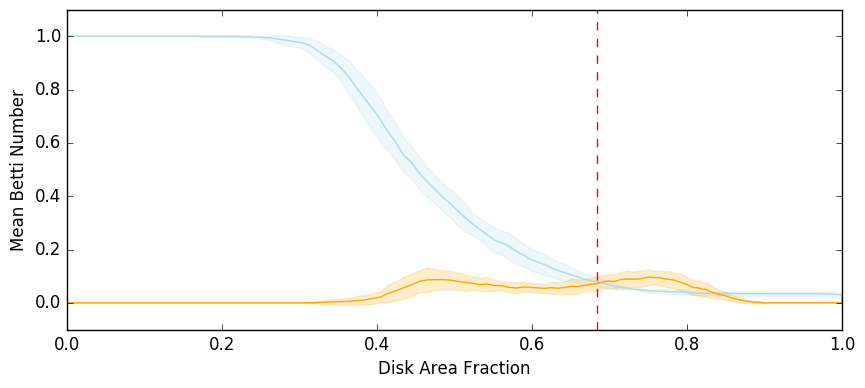

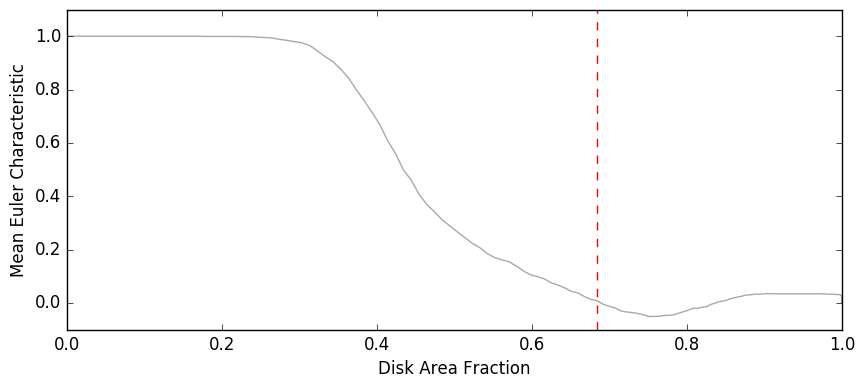

ϕ_c = 0.6837389022396216 (est.)

In [14]:
cond = "Clustered" 

betti_0_reps = zeros(size(repetitions)[1], 1001)
betti_1_reps = zeros(size(repetitions)[1], 1001)
euler_characteristics = zeros(size(repetitions)[1], 1001)

phi_vals = nothing
eta_vals = nothing

for rep in repetitions
        
    filepath = parent_folder * "/" * cond * "_" * string(rep) * "_rep/Pos_200000.dat"

    posarray = readdlm(filepath, ',', '\n');
    posx = [];
    posy = []
    for j in 1:size(posarray)[2]
        complex_num = parse(Complex{Float64}, posarray[j])
        push!(posx, real(complex_num));
        push!(posy, imag(complex_num));
    end

    final_positions = transpose(hcat(posx, posy));

    pers_diag = eirene(final_positions, model="pc", maxdim=1);

    TDA_barcode_dim0 = barcode(pers_diag, dim=0)
    TDA_barcode_dim1 = barcode(pers_diag, dim=1)

    (b0, b1, phi, eta, chi) = get_betti_curves(TDA_barcode_dim0, TDA_barcode_dim1);
    
    phi_vals = phi
    eta_vals = eta
    
    betti_0_reps[rep,:] = b0
    betti_1_reps[rep,:] = b1
    euler_characteristics[rep,:] = chi
    
end

mean_betti_0 = mean(betti_0_reps, dims=1)
mean_betti_1 = mean(betti_1_reps, dims=1)
mean_betti_0 = reduce(vcat, mean_betti_0)
mean_betti_1 = reduce(vcat, mean_betti_1)

std_betti_0 = std(betti_0_reps, dims=1)
std_betti_0 = reduce(vcat, std_betti_0)
std_betti_1 = std(betti_1_reps, dims=1)
std_betti_1 = reduce(vcat, std_betti_1)

χ̄ = mean(euler_characteristics, dims=1)
χ̄ = reduce(vcat, χ̄)

cur_diff = 1.0
cur_idx = 0
cnt = 1

for ec_val in χ̄
    
    if abs(ec_val - 0.0) < cur_diff
        cur_diff = ec_val
        cur_idx = cnt
    end
    if ec_val < 0
       break 
    end
    cnt += 1
    
end
ϕ_c = phi_vals[cnt-1]
print("ϕ_c = " * string(ϕ_c) * " (est.)")

figure(figsize=(10,4), dpi=300)
fill_between(phi_vals, mean_betti_0-std_betti_0, mean_betti_0+std_betti_0, color="lightblue", alpha=0.2)
fill_between(phi_vals, mean_betti_1-std_betti_1, mean_betti_1+std_betti_1, color="orange", alpha=0.2)
plot(phi_vals, mean_betti_0, color="lightblue", "-")
plot(phi_vals, mean_betti_1, color="orange", "-")
if ϕ_c < 0.99
    plot([ϕ_c, ϕ_c], [-0.1, 1.1], color="red", "--")
end
xlim([0, 1])
ylim([-0.1, 1.1])
xlabel("Disk Area Fraction")
ylabel("Mean Betti Number")
show()

figure(figsize=(10,4), dpi=300)
plot(phi_vals, χ̄, color="darkgray", "-")
if ϕ_c < 0.99
    plot([ϕ_c, ϕ_c], [-0.1, 1.1], color="red", "--")
end
xlim([0, 1])
ylim([-0.1, 1.1])
xlabel("Disk Area Fraction")
ylabel("Mean Euler Characteristic")
show()

In [15]:
num_loops = Dict()
loop_size = Dict()
num_neighbors = Dict()

for cond in conditions
    
    num_loops[cond] = []
    loop_size[cond] = []
    num_neighbors[cond] = []
    
    for rep in repetitions
        
        filepath = parent_folder * "/" * cond * "_" * string(rep) * "_rep/Pos_200000.dat"
        
        posarray = readdlm(filepath, ',', '\n');
        posx = [];
        posy = []
        for j in 1:size(posarray)[2]
            complex_num = parse(Complex{Float64}, posarray[j])
            push!(posx, real(complex_num));
            push!(posy, imag(complex_num));
        end
        
        final_positions = transpose(hcat(posx, posy));
        
        filepath = parent_folder * "/" * cond * "_" * string(rep) * "_rep/Neighbors_200000.dat"
        neighbors = readdlm(filepath, ',', '\n')
        
        pers_diag = eirene(final_positions, model="pc", maxdim=1);
        
        TDA_barcode_dim1 = barcode(pers_diag, dim=1)
        
        dim1_bar_lengths = TDA_barcode_dim1[:,2] - TDA_barcode_dim1[:,1]
        filtered_dim1_bars = TDA_barcode_dim1[:,2][TDA_barcode_dim1[:,2] .> 1.4269414844344528]
        
        n_loops = size(filtered_dim1_bars)[1]
        
        append!(num_loops[cond], mean(n_loops))
        append!(loop_size[cond], filtered_dim1_bars)
        append!(num_neighbors[cond], mean(neighbors))
    
    end
    
end

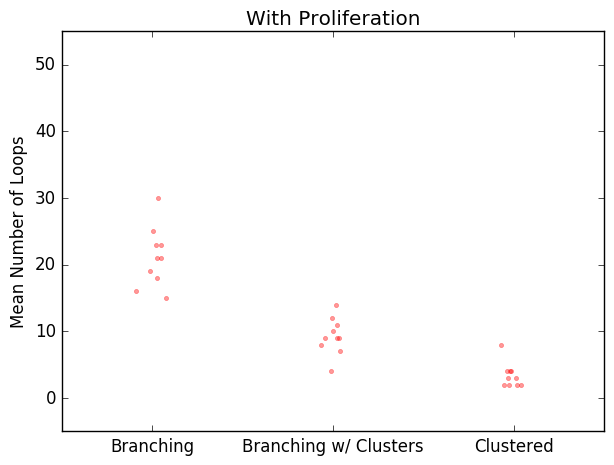

In [16]:
fig = figure(1, figsize=(7,5), dpi=300)
ax = fig.add_subplot(111)

median_properties = Dict()
median_properties["color"] = "blue"
median_properties["linewidth"] = 0.0
whisker_properties = Dict()
whisker_properties["linewidth"] = 0.0

bp = ax.boxplot([num_loops["Spanning"], num_loops["SpanningWClusters"], num_loops["Clustered"]],
    notch=false, showbox=false, showcaps=false, showfliers=false,
    medianprops=median_properties, whiskerprops=whisker_properties)

xticlabels = ["Spanning", "SpanningWClusters", "Clustered"]
xticdisp = ["Branching", "Branching w/ Clusters", "Clustered"]
xticks([1, 2, 3], xticdisp);

for i in [1, 2, 3]
    ys = num_loops[xticlabels[i]]
    xs = rand(Normal(i, 0.04), size(ys)[1])
    plot(xs, ys, "r.", alpha=0.4)
end

ylabel("Mean Number of Loops")
title("With Proliferation")
ylim([-5, 55])
fig.savefig("prolif_num_loops.png", bbox_inches="tight")

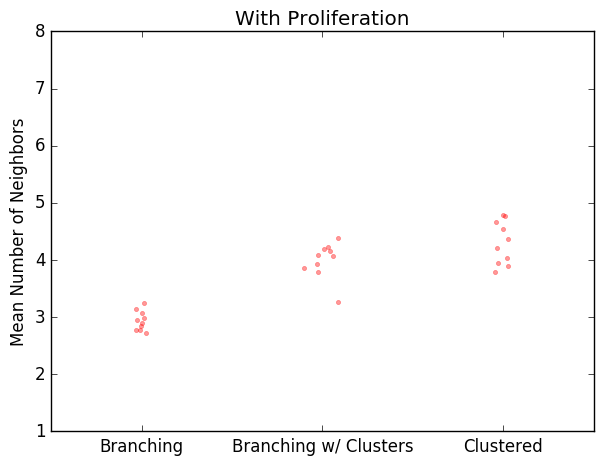

In [17]:
fig = figure(1, figsize=(7,5), dpi=300)
ax = fig.add_subplot(111)

median_properties = Dict()
median_properties["color"] = "blue"
median_properties["linewidth"] = 0.0
whisker_properties = Dict()
whisker_properties["linewidth"] = 0.0

bp = ax.boxplot([num_neighbors["Spanning"], num_neighbors["SpanningWClusters"], num_neighbors["Clustered"]],
    notch=false, showbox=false, showcaps=false, showfliers=false,
    medianprops=median_properties, whiskerprops=whisker_properties)

xticlabels = ["Spanning", "SpanningWClusters", "Clustered"]
xticdisp = ["Branching", "Branching w/ Clusters", "Clustered"]
xticks([1, 2, 3], xticdisp);

for i in [1, 2, 3]
    ys = num_neighbors[xticlabels[i]]
    xs = rand(Normal(i, 0.04), size(ys)[1])
    plot(xs, ys, "r.", alpha=0.4)
end

ylabel("Mean Number of Neighbors")
title("With Proliferation")
ylim([1, 8])
fig.savefig("prolif_num_neighbors.png", bbox_inches="tight")

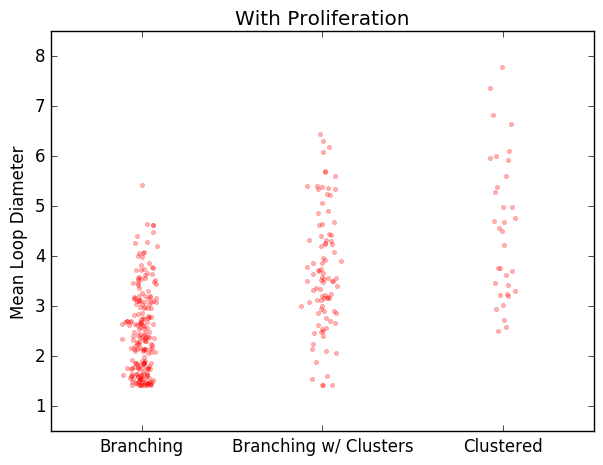

In [18]:
fig = figure(1, figsize=(7,5), dpi=300)
ax = fig.add_subplot(111)

median_properties = Dict()
median_properties["color"] = "blue"
median_properties["linewidth"] = 0.0
whisker_properties = Dict()
whisker_properties["linewidth"] = 0.0

bp = ax.boxplot([loop_size["Spanning"], loop_size["SpanningWClusters"], loop_size["Clustered"]], 
    notch=false, showbox=false, showcaps=false, showfliers=false,
    medianprops=median_properties, whiskerprops=whisker_properties)

xticlabels = ["Spanning", "SpanningWClusters", "Clustered"]
xticdisp = ["Branching", "Branching w/ Clusters", "Clustered"]
xticks([1, 2, 3], xticdisp);

for i in [1, 2, 3]
    ys = loop_size[xticlabels[i]]
    xs = rand(Normal(i, 0.04), size(ys)[1])
    plot(xs, ys, "r.", alpha=0.3)
end

ylabel("Mean Loop Diameter")
title("With Proliferation")
ylim([0.5, 8.5])
fig.savefig("prolif_loop_radii.png", bbox_inches="tight")

In [19]:
# equilibrium distance
r_eq = 1.009

# effective particle size
sigma = r_eq/2 

cond = "Clustered"
num_loops_min = minimum(num_loops[cond])
num_loops_max = maximum(num_loops[cond])
loop_dm = mean(loop_size[cond])/sigma

print(cond * " Condition\n")
print("Number of loops in range: " * repr(num_loops_min) * " - " * repr(num_loops_max) * "\n")
print("Mean Loop Diameter: " * repr(loop_dm) * " sigma\n")
print("Mean Loop Diameter: " * repr(mean(loop_size[cond])) * "\n")

Clustered Condition
Number of loops in range: 2.0 - 8.0
Mean Loop Diameter: 9.032769894423971 sigma
Mean Loop Diameter: 4.557032411736893


### Representative Barcode

In [20]:
function get_pos(fpath)
  
    posarray = readdlm(fpath, ',', '\n');
    posx = [];
    posy = []
    for j in 1:size(posarray)[2]
        complex_num = parse(Complex{Float64}, posarray[j])
        push!(posx, real(complex_num));
        push!(posy, imag(complex_num));
    end
    
    return(posx, posy)
    
end

function plot_persistence_diag(dim0barcode_data, dim1barcode_data, x_lim=nothing, y_lim=nothing)
    
    dim0_bar_lengths = dim0barcode_data[:,2] - dim0barcode_data[:,1]
    max_dim1_x = maximum(dim1barcode_data[:,1])
    max_x = max_dim1_x
    max_y = 0.0
    
    figure(figsize=(5,5), dpi=300)
    
    for i in range(1, length=length(dim0_bar_lengths))
        len = dim0_bar_lengths[i]
        if len != Inf
            if len > max_y
                max_y = len
            end
            #scatter(dim0barcode_data[i,1], dim0barcode_data[i,2], color=:blue, s=16)
        end
    end
    
    max_dim1_y = maximum(dim1barcode_data[:,2])
    max_y = maximum([max_y, max_dim1_y])
    
    scatter(dim1barcode_data[:,1], dim1barcode_data[:,2], color=:darkorange, s=16)
    dim1_bar_lengths = dim1barcode_data[:,2] - dim1barcode_data[:,1]
    s_idx = sortperm(dim1_bar_lengths, alg=QuickSort)
    dim1barcode_data_sorted = dim1barcode_data[s_idx,:]
    scatter(dim1barcode_data_sorted[end,1], dim1barcode_data_sorted[end,2], color=:red, s=16)

    max_plot_len = maximum([max_x, max_y])
    plot([0, max_plot_len+2], [0, max_plot_len+2], color=:black, "--")
    plot([0, max_plot_len+2], [1.4269414844344528, 1.4269414844344528], color=:red, "--")
    
    if isnothing(x_lim)
        xlim([-0.1, max_x+0.5])
    else
        xlim([-0.1, x_lim+0.5])
    end
    if isnothing(y_lim)
        ylim([-0.1, max_y+0.5])
    else
        ylim([-0.1, y_lim+0.5])
    end
    
    # plot final dim 0 barcode at infty
    #=
    if isnothing(y_lim)
        scatter(0.0, max_y+0.5-0.02, color=:blue, s=16)
    else
        scatter(0.0, y_lim+0.5-0.02, color=:blue, s=16)
    end
    =#
    
    xlabel(L"$\epsilon$")
    ylabel(L"$\epsilon$")
    show()
    
end;


function plot_cell_pos(posx, posy, condition, dim1_loop, dim1_loop_r, zoom=false)
    
    figure(figsize=(5,5), dpi=300)
    
    scatter(posx, posy, color="black", s=12)
    for seg_idx in range(1, length=size(dim1_loop)[2])
        cid_1 = dim1_loop[1, seg_idx]
        cid_2 = dim1_loop[2, seg_idx]
        pos_1_x = posx[cid_1]
        pos_1_y = posy[cid_1]
        pos_2_x = posx[cid_2]
        pos_2_y = posy[cid_2]
        plot([pos_1_x, pos_2_x], [pos_1_y, pos_2_y], "r-")
    end
    
    if (zoom)
        xlim([-8, 8])
        ylim([-8, 8])
    else
        xlim([-10, 10])
        ylim([-10, 10])
    end
    
    xticks([])
    yticks([])
    title(condition * "\n", fontsize=14)
    
    ax = gca()
    ax.spines["top"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    
    for c_idx in range(1, stop=size(posx)[1])
        
        ax.add_artist(PyPlot.plt.Circle((posx[c_idx], posy[c_idx]), dim1_loop_r/2, color="gray", alpha=0.1))
        
    end
    
    show()
    
end;

function plot_barcode(TDA_barcode, sort_barcode=false, xlims=nothing, y_padding=0, plot_dim0=0)
    
    bar_lengths = TDA_barcode[:,2] - TDA_barcode[:,1]
    s_idx = sortperm(bar_lengths, alg=QuickSort)
    num_bars = size(s_idx)[1]
    
    if sort_barcode
        barcode_sorted = TDA_barcode[s_idx,:]
    else
        barcode_sorted = TDA_barcode
    end
    
    figure(figsize=(5,5), dpi=300)
    y_val = 0.1
    for itr in range(1, stop=num_bars)
        if itr == num_bars
            clr = "red"
            plot([barcode_sorted[itr, 1], barcode_sorted[itr, 2]], [y_val, y_val], linewidth=2, color=clr)
        else
            clr = "lightblue"
            if plot_dim0 == 0
                clr = "orange"
            end
            plot([barcode_sorted[itr, 1], barcode_sorted[itr, 2]], [y_val, y_val], linewidth=2, color=clr)   
        end
        #scatter(barcode_sorted[itr, 1], y_val, color=clr, s=4)
        #scatter(barcode_sorted[itr, 2], y_val, color=clr, s=4)
        y_val += 0.1
    end
    
    if isnothing(xlims)
        xlim([0, maximum(TDA_barcode[:,2])])
    else
        if plot_dim0 == 1
            #plot([0, xlims[2]], [y_val-0.1, y_val-0.1], linewidth=2, color="blue")
            quiver(0, y_val-0.05, xlims[2], 0, scale=xlims[2], linewidth=0.15, 
                color="lightblue", edgecolor="lightblue")
        end
        xlim(xlims)
    end
    
    if plot_dim0 == 0
        plot([1.4269414844344528, 1.4269414844344528], [-y_padding, y_val+y_padding], color="red", "--")
    end
        
    ylim([-y_padding, y_val+y_padding])
    yticks([])
    ax = gca()
    ax.tick_params(width=1.5, top=false)
    ax.spines["top"].set_visible(false)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_visible(false)
    ax.spines["right"].set_visible(false)
    show()
    
end;

#### Without proliferation

In [21]:
parent_folder = "no_prolif_timelapse"
conditions = ["Clustered", "Spanning", "SpanningWClusters", "Individual"];

Clustered Eps Start: 5.609947488167782, Eps End: 6.466431350443612, Num Loops: 83
Spanning Eps Start: 2.5693214524157875, Eps End: 4.31881767617018, Num Loops: 53
SpanningWClusters Eps Start: 3.3172747881355864, Eps End: 4.198635083274087, Num Loops: 70
Individual Eps Start: 1.8199537631489389, Eps End: 3.701109883534936, Num Loops: 51


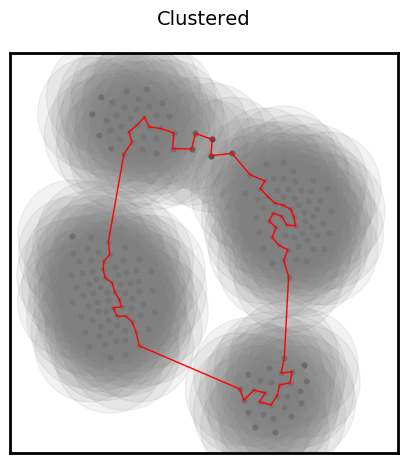

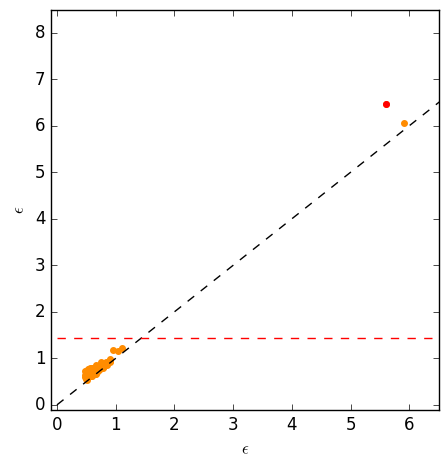

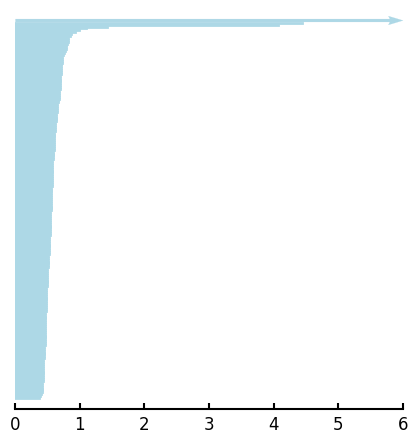

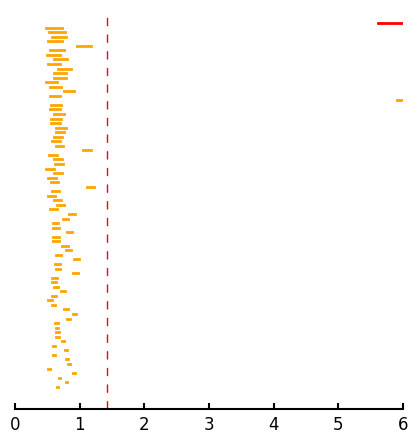

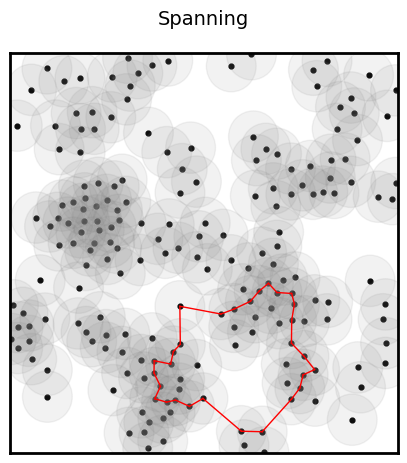

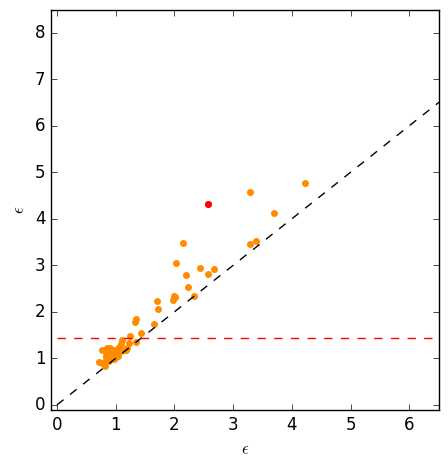

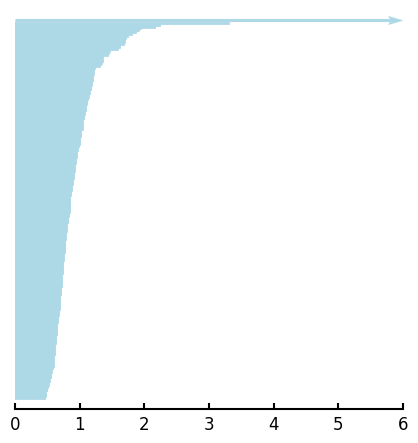

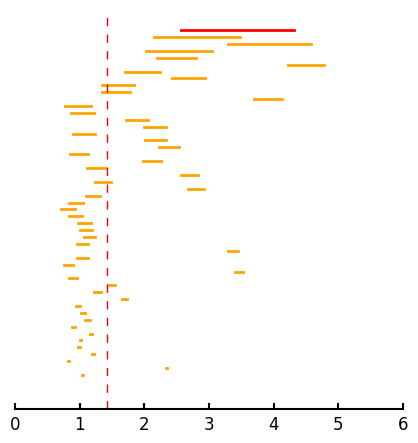

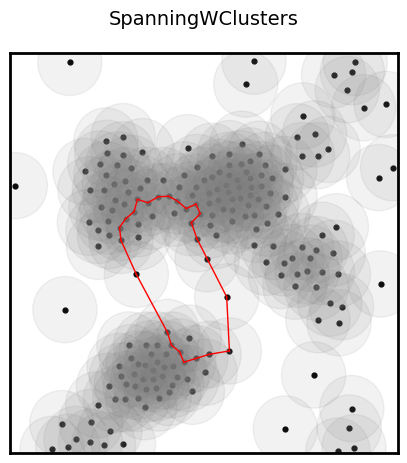

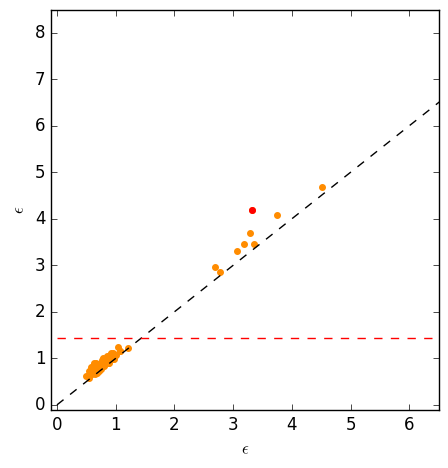

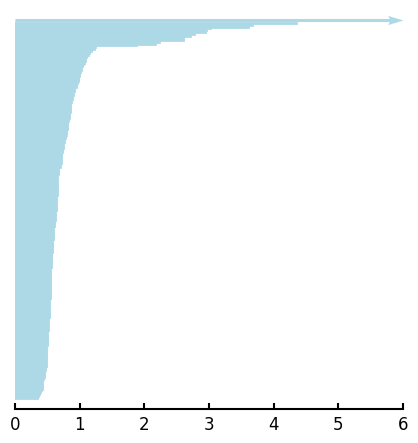

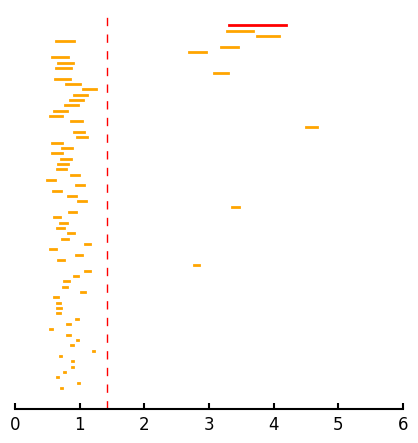

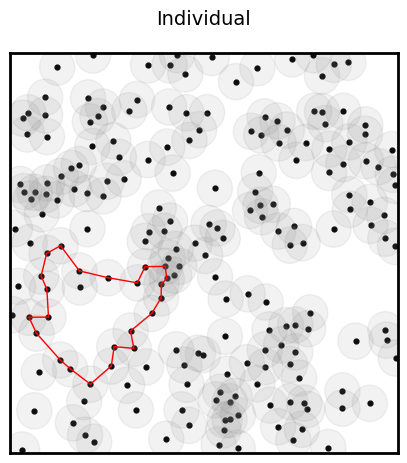

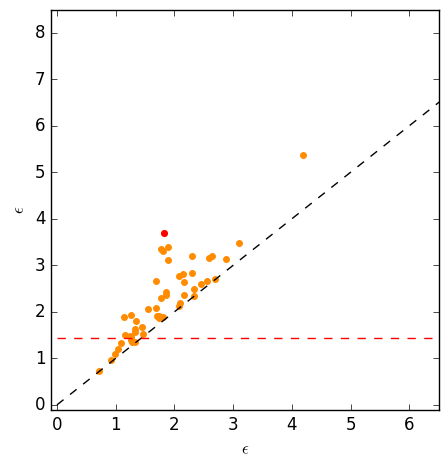

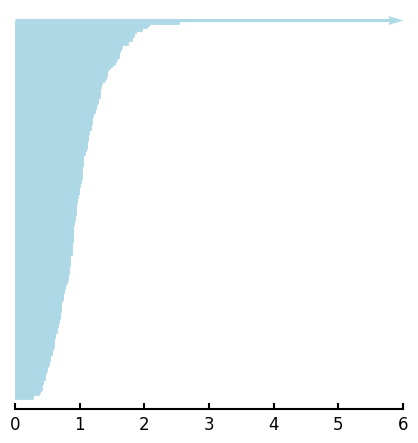

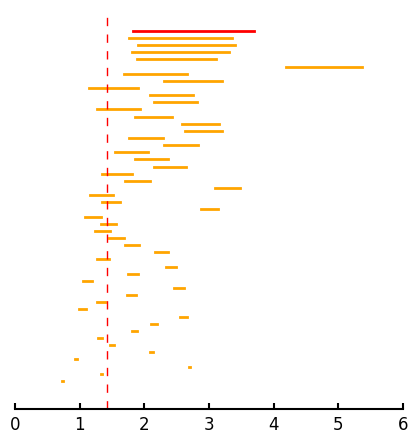

In [22]:
for cond in conditions
    
    fpath = parent_folder * "/" * cond * "_1_rep/Pos_200000.dat"
    
    (posx, posy) = get_pos(fpath)

    final_positions = transpose(hcat(posx, posy));

    pers_diag = eirene(final_positions, model="pc", maxdim=1);
    
    TDA_barcode_dim0 = barcode(pers_diag, dim=0)
    TDA_barcode_dim1 = barcode(pers_diag, dim=1)
    
    dim1_bar_lengths = TDA_barcode_dim1[:,2] - TDA_barcode_dim1[:,1]
    s_idx = sortperm(dim1_bar_lengths, alg=QuickSort)
    num_holes = size(s_idx)[1]
    dim1barcode_sorted_inc = TDA_barcode_dim1[s_idx,:]
    
    dim1_loop = classrep(pers_diag, class=s_idx[end], dim=1)
    loop_eps_start = dim1barcode_sorted_inc[end,1]
    loop_eps_end = dim1barcode_sorted_inc[end,2]
    
    print(cond * " Eps Start: " * repr(loop_eps_start) * ", Eps End: " * repr(loop_eps_end) * ", Num Loops: " 
        * repr(num_holes) * "\n")
    
    plot_cell_pos(posx, posy, cond, dim1_loop, loop_eps_start, false)
    plot_persistence_diag(TDA_barcode_dim0, TDA_barcode_dim1, 6, 8)
    
    plot_barcode(TDA_barcode_dim0, true, [0, 6], 0.5, 1)
    plot_barcode(TDA_barcode_dim1, true, [0, 6], 0.2, 0)
    
end

#### With proliferation enabled

In [23]:
parent_folder = "prolif_timelapse"
conditions = ["Clustered", "Spanning", "SpanningWClusters"];

Clustered Eps Start: 5.043691192807109, Eps End: 7.377501127075482, Num Loops: 64
Spanning Eps Start: 1.3775567683402383, Eps End: 3.9932901713374145, Num Loops: 86


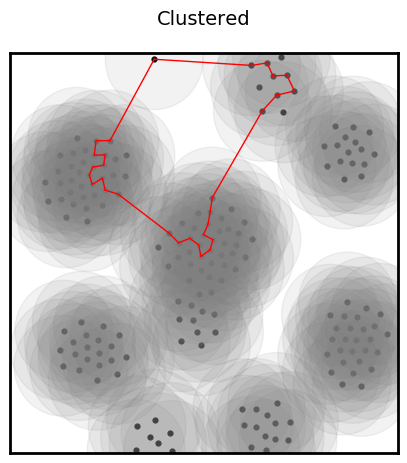

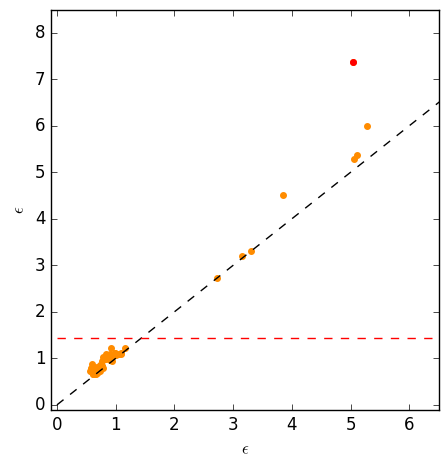

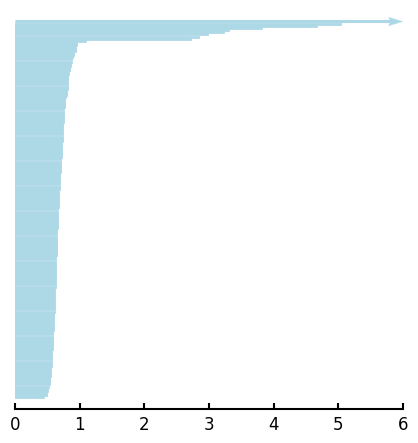

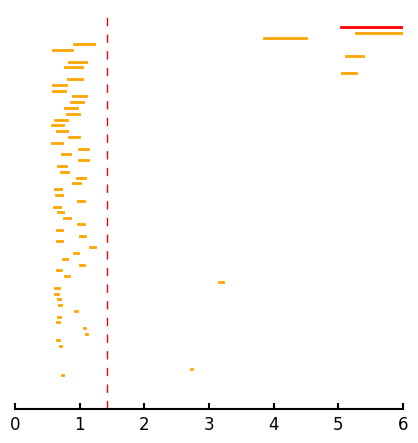

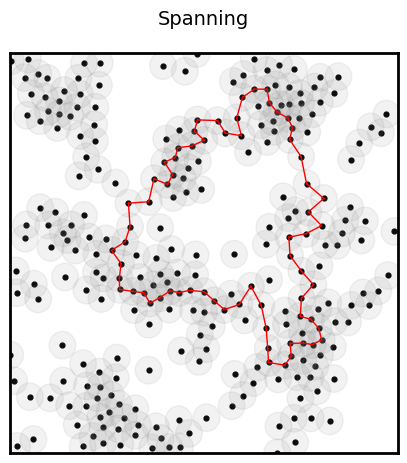

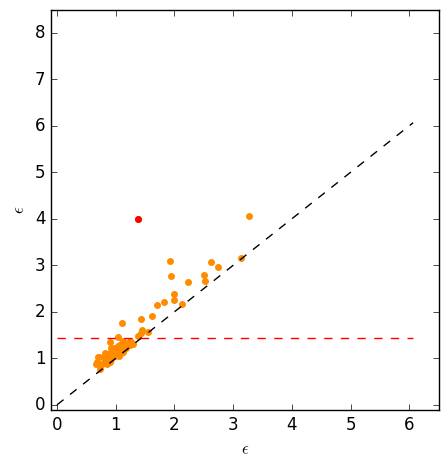

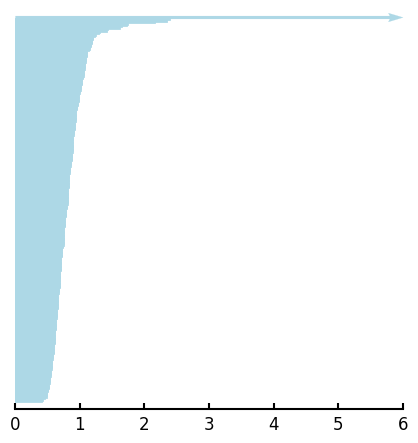

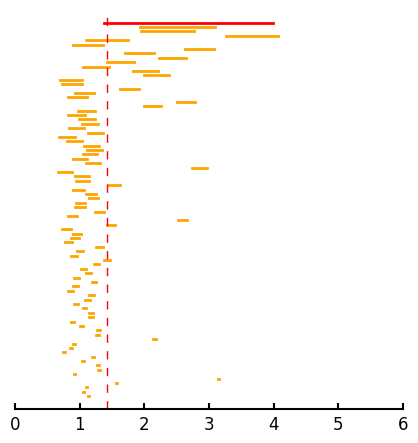

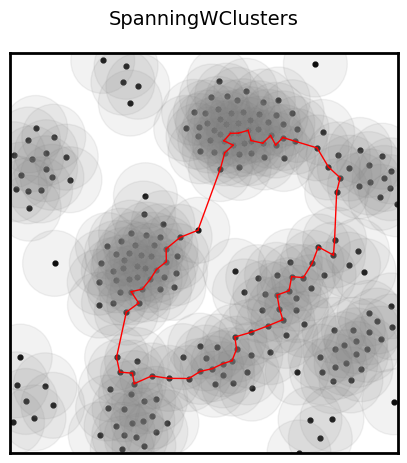

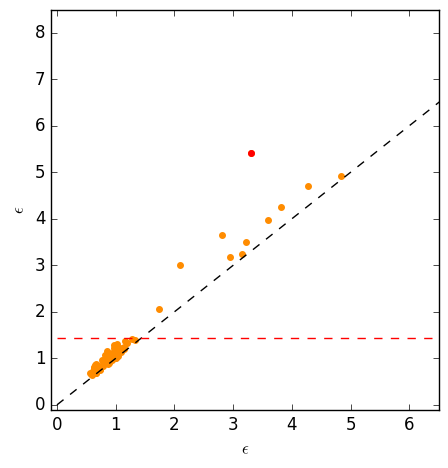

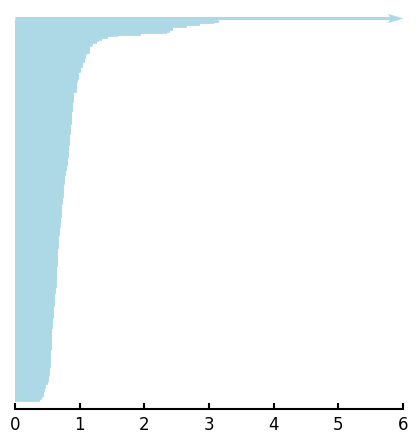

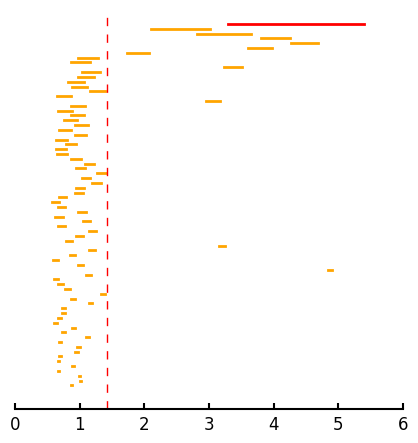

SpanningWClusters Eps Start: 3.2958673007874575, Eps End: 5.405047478977405, Num Loops: 78


In [24]:
for cond in conditions
    
    fpath = parent_folder * "/" * cond * "_1_rep/Pos_200000.dat"
    
    (posx, posy) = get_pos(fpath)

    final_positions = transpose(hcat(posx, posy));

    pers_diag = eirene(final_positions, model="pc", maxdim=1);
    
    TDA_barcode_dim0 = barcode(pers_diag, dim=0)
    TDA_barcode_dim1 = barcode(pers_diag, dim=1)
    
    dim1_bar_lengths = TDA_barcode_dim1[:,2] - TDA_barcode_dim1[:,1]
    s_idx = sortperm(dim1_bar_lengths, alg=QuickSort)
    num_holes = size(s_idx)[1]
    dim1barcode_sorted_inc = TDA_barcode_dim1[s_idx,:]
    
    dim1_loop = classrep(pers_diag, class=s_idx[end], dim=1)
    loop_eps_start = dim1barcode_sorted_inc[end,1]
    loop_eps_end = dim1barcode_sorted_inc[end,2]
    
    print(cond * " Eps Start: " * repr(loop_eps_start) * ", Eps End: " * repr(loop_eps_end) * ", Num Loops: " 
        * repr(num_holes) * "\n")
    
    plot_cell_pos(posx, posy, cond, dim1_loop, loop_eps_start, false)
    plot_persistence_diag(TDA_barcode_dim0, TDA_barcode_dim1, 6, 8)
    
    plot_barcode(TDA_barcode_dim0, true, [0, 6], 0.5, 1)
    plot_barcode(TDA_barcode_dim1, true, [0, 6], 0.2, 0)
    
end